In [ ]:
import kagglehub
shilongzhuang_telecom_customer_churn_by_maven_analytics_path = kagglehub.dataset_download('shilongzhuang/telecom-customer-churn-by-maven-analytics')

print('Data source import complete.')

100%|██████████| 434k/434k [00:00<00:00, 78.6MB/s]

Extracting files...
Data source import complete.


In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


import missingno as msno
from scipy.stats import trim_mean, kurtosis, skew

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from imblearn.combine import SMOTETomek

from sklearn.model_selection import train_test_split, GridSearchCV

import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, f1_score

from time import perf_counter

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!gdown --id 1pRVk_O_hy9LVuHNWbDrdagZlI8WgRUNr -O dataset.csv
data = pd.read_csv('/content/telecom_customer_churn.csv')

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pRVk_O_hy9LVuHNWbDrdagZlI8WgRUNr
To: /content/dataset.csv
100% 1.44M/1.44M [00:00<00:00, 13.3MB/s]


In [ ]:
data = data.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns')

In [ ]:
data.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,...,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [ ]:
data['customer_status'] = data['customer_status'].replace('Joined', 'Stayed')

In [ ]:
data.shape

(7043, 38)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   gender                             7043 non-null   object 
 2   age                                7043 non-null   int64  
 3   married                            7043 non-null   object 
 4   number_of_dependents               7043 non-null   int64  
 5   city                               7043 non-null   object 
 6   zip_code                           7043 non-null   int64  
 7   latitude                           7043 non-null   float64
 8   longitude                          7043 non-null   float64
 9   number_of_referrals                7043 non-null   int64  
 10  tenure_in_months                   7043 non-null   int64  
 11  offer                              3166 non-null   objec

In [ ]:
data = data.drop(['customer_id', 'city', 'zip_code', 'latitude', 'longitude',], axis=1)

In [ ]:
data = data.drop(['churn_category', 'churn_reason'], axis=1)

In [ ]:
data.duplicated().sum()

np.int64(0)

In [ ]:
data.describe(include='O').T

,count,unique,top,freq
gender,7043,2,Male,3555
married,7043,2,No,3641
offer,3166,5,Offer B,824
phone_service,7043,2,Yes,6361
multiple_lines,6361,2,No,3390
internet_service,7043,2,Yes,5517
internet_type,5517,3,Fiber Optic,3035
online_security,5517,2,No,3498
online_backup,5517,2,No,3088
device_protection_plan,5517,2,No,3095


In [ ]:
rows, cols = 5, 4
plots_per_figure = rows * cols
categorical_cols = [col for col in data.select_dtypes(include=['object']).columns]
num_plots = len(categorical_cols)

# Create figure with subplots
fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=[f"Distribution of {col}" for col in categorical_cols[:plots_per_figure]],
    vertical_spacing=0.1,
    horizontal_spacing=0.05
)

# Plot each categorical column
for i, col in enumerate(categorical_cols[:plots_per_figure]):
    row = (i // cols) + 1
    col_idx = (i % cols) + 1

    # Get value counts
    counts = data[col].value_counts().reset_index()
    counts.columns = [col, 'count']

    # Add bar trace
    fig.add_trace(
        go.Bar(
            x=counts[col],
            y=counts['count'],
            text=counts['count'],
            textposition='auto',
            textfont=dict(size=10),
            marker_color=px.colors.sequential.Viridis
        ),
        row=row,
        col=col_idx
    )

    # Update x-axis for rotation
    fig.update_xaxes(
        tickangle=20,
        tickfont=dict(size=9),
        row=row,
        col=col_idx
    )

    # Update y-axis
    fig.update_yaxes(
        title_text="Count",
        titlefont=dict(size=10),
        tickfont=dict(size=9),
        row=row,
        col=col_idx
    )

# Update layout
fig.update_layout(
    height=1200,
    width=900,
    showlegend=False,
    title_text="Categorical Distributions",
    title_x=0.5,
    title_font=dict(size=14),
    margin=dict(l=50, r=50, t=80, b=50)
)

# Show figure
fig.show()

In [ ]:
rows, cols = 3, 3
plots_per_figure = rows * cols
categorical_cols = [col for col in data.select_dtypes(include=['object']).columns if col != 'customer_status']
num_plots = len(categorical_cols)
num_figures = (num_plots + plots_per_figure - 1) // plots_per_figure  # Ceiling division

# Unique customer_status values for legend
statuses = data['customer_status'].unique()
colors = px.colors.qualitative.Set2[:len(statuses)]  # Match colors to unique statuses

# Create a figure for each set of 6 plots
for fig_idx in range(num_figures):
    start_idx = fig_idx * plots_per_figure
    end_idx = min(start_idx + plots_per_figure, num_plots)
    current_cols = categorical_cols[start_idx:end_idx]

    # Create subplot grid for this figure
    fig = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=[f"Distribution of {col}" for col in current_cols],
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )

    # Plot each categorical column
    for i, col in enumerate(current_cols):
        row = (i // cols) + 1
        col_idx = (i % cols) + 1

        # Group by column and customer_status to get counts
        counts = data.groupby([col, 'customer_status']).size().reset_index(name='count')

        # Add bars for each customer_status value
        for j, status in enumerate(statuses):
            status_data = counts[counts['customer_status'] == status]
            fig.add_trace(
                go.Bar(
                    x=status_data[col],
                    y=status_data['count'],
                    name=status,
                    text=status_data['count'],
                    textposition='auto',
                    textfont=dict(size=10),
                    marker_color=colors[j],
                    showlegend=(i == 0)  # Show legend only for the first subplot
                ),
                row=row,
                col=col_idx
            )

        # Update x-axis for rotation
        fig.update_xaxes(
            tickangle=45,
            tickfont=dict(size=9),
            row=row,
            col=col_idx
        )

        # Update y-axis for consistency
        fig.update_yaxes(
            title_text="Count",
            titlefont=dict(size=10),
            tickfont=dict(size=9),
            row=row,
            col=col_idx
        )

    # Update layout
    fig.update_layout(
        height=800,
        width=900,
        showlegend=True,
        barmode='stack',
        title_text=f"Categorical Distributions by Customer Status",
        title_x=0.5,
        title_font=dict(size=14),
        legend=dict(
            x=1.05,
            y=0.5,
            font=dict(size=10)
        ),
        margin=dict(l=50, r=150, t=80, b=50)
    )

    # Show the figure
    fig.show()

In [ ]:
data.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
age,7043.0,46.509726,16.750352,19.00,32.000,46.00,60.000,80.00
number_of_dependents,7043.0,0.468692,0.962802,0.00,0.000,0.00,0.000,9.00
number_of_referrals,7043.0,1.951867,3.001199,0.00,0.000,0.00,3.000,11.00
tenure_in_months,7043.0,32.386767,24.542061,1.00,9.000,29.00,55.000,72.00
avg_monthly_long_distance_charges,6361.0,25.420517,14.200374,1.01,13.050,25.69,37.680,49.99
avg_monthly_gb_download,5517.0,26.189958,19.586585,2.00,13.000,21.00,30.000,85.00
monthly_charge,7043.0,63.596131,31.204743,-10.00,30.400,70.05,89.750,118.75
total_charges,7043.0,2280.381264,2266.220462,18.80,400.150,1394.55,3786.600,8684.80
total_refunds,7043.0,1.962182,7.902614,0.00,0.000,0.00,0.000,49.79
total_extra_data_charges,7043.0,6.860713,25.104978,0.00,0.000,0.00,0.000,150.00


In [ ]:
rows, cols = 3, 4
numeric_cols = data.select_dtypes(include=['number']).columns

# Create figure with subplots
fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=[f"Distribution of {col}" for col in numeric_cols],
    vertical_spacing=0.15,
    horizontal_spacing=0.05
)

# Plot each numeric column
for i, col in enumerate(numeric_cols):
    row = (i // cols) + 1
    col_idx = (i % cols) + 1

    # Create histogram
    fig.add_trace(
        go.Histogram(
            x=data[col],
            nbinsx=30,
            histnorm='probability density',
            name=col,
            marker_color='skyblue'
        ),
        row=row,
        col=col_idx
    )

    # Add kernel density estimation
    if not data[col].isna().all():
        from scipy import stats
        kernel = stats.gaussian_kde(data[col].dropna())
        x_range = np.linspace(data[col].min(), data[col].max(), 100)
        fig.add_trace(
            go.Scatter(
                x=x_range,
                y=kernel(x_range),
                mode='lines',
                name='KDE',
                line=dict(color='red')
            ),
            row=row,
            col=col_idx
        )

    # Update axes
    fig.update_xaxes(
        title_text=col,
        titlefont=dict(size=10),
        tickfont=dict(size=9),
        row=row,
        col=col_idx
    )
    fig.update_yaxes(
        title_text="Density",
        titlefont=dict(size=10),
        tickfont=dict(size=9),
        row=row,
        col=col_idx
    )

# Update layout
fig.update_layout(
    height=900,
    width=1500,
    showlegend=False,
    title_text="Numeric Distributions",
    title_x=0.5,
    title_font=dict(size=14),
    margin=dict(l=50, r=50, t=100, b=50)
)

# Show figure
fig.show()

In [ ]:
# Define columns for groupby
groupby_columns = ['age', 'monthly_charge', 'total_charges', 'total_revenue', 'total_refunds']

# using groupby
groupby_result = data.groupby('customer_status')[groupby_columns].agg(lambda x: trim_mean(x, 0.05))

# Display the result
print("Groupby:")
groupby_result

Groupby:


,age,monthly_charge,total_charges,total_revenue,total_refunds
customer_status,,,,,
Churned,49.749257,74.780303,1322.459982,1699.445383,0.048604
Stayed,44.990983,59.929347,2401.464146,3240.518298,0.395058


The Highest Correlation among Features:


,0
age,avg_monthly_gb_download
number_of_dependents,avg_monthly_gb_download
number_of_referrals,tenure_in_months
tenure_in_months,total_revenue
avg_monthly_long_distance_charges,total_long_distance_charges
avg_monthly_gb_download,age
monthly_charge,total_charges
total_charges,total_revenue
total_refunds,tenure_in_months
total_extra_data_charges,total_revenue


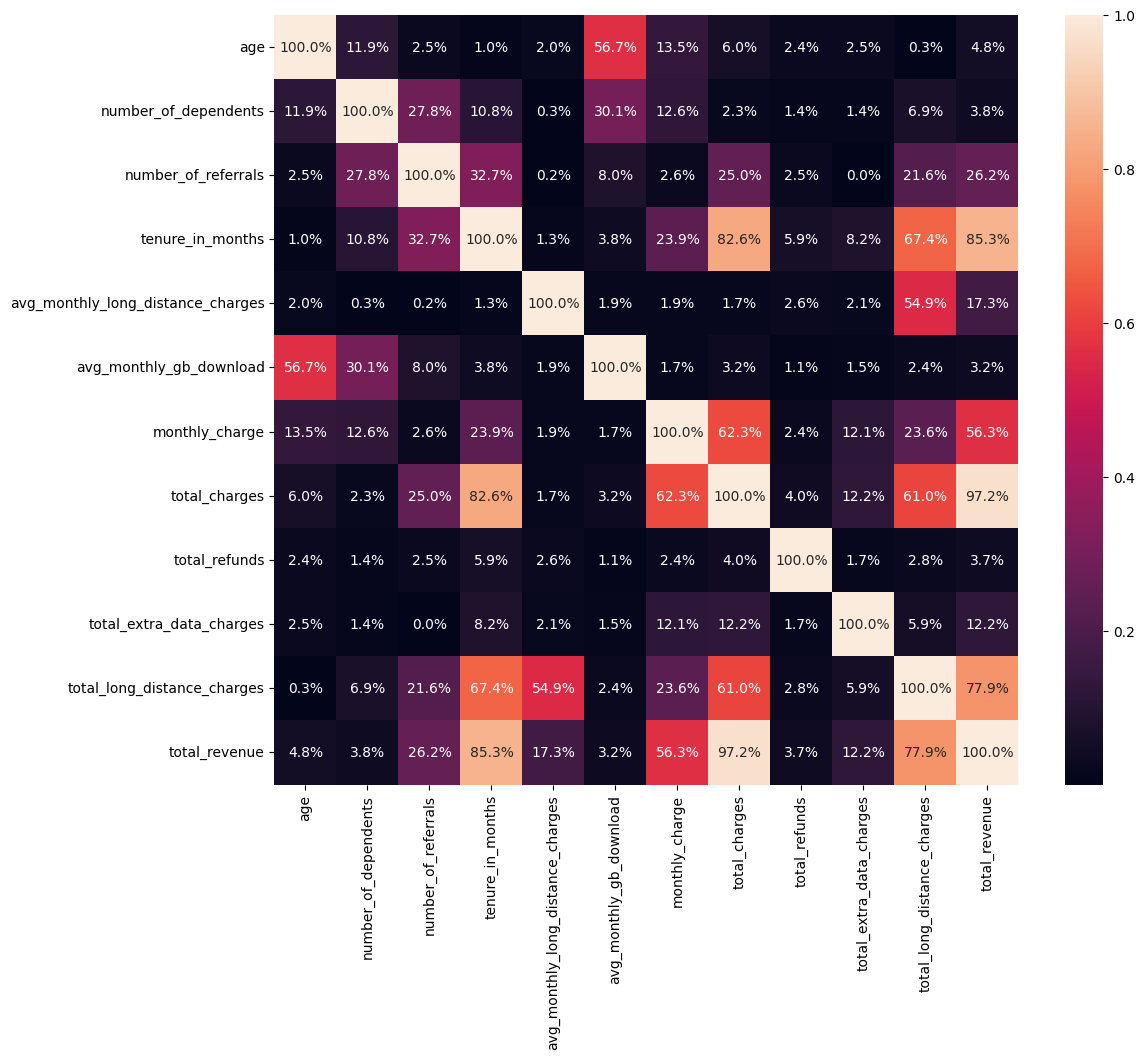

In [ ]:
# heat map
corr_mat = data.select_dtypes(include=['number']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat.abs(), annot=True, fmt=".1%")

print('The Highest Correlation among Features:')
for x in range(len(data.select_dtypes(include=['number']).columns)):
  corr_mat.iloc[x,x] = 0.0
corr_mat.abs().idxmax()

In [ ]:
data = data.drop(['total_charges'],axis=1)

# **Preprocessing**

In [ ]:
numeric_data = data.select_dtypes(include=['number'])

# Calculate skewness of numerical features
skewness = numeric_data.apply(skew)

print("Skewness of numerical features:")
print(skewness)

Skewness of numerical features:
age                                  0.162152
number_of_dependents                 2.109483
number_of_referrals                  1.445752
tenure_in_months                     0.240491
avg_monthly_long_distance_charges         NaN
avg_monthly_gb_download                   NaN
monthly_charge                      -0.275335
total_refunds                        4.327595
total_extra_data_charges             4.090338
total_long_distance_charges          1.238018
total_revenue                        0.919214
dtype: float64


In [ ]:
# Define the columns to transform
columns_to_transform = ['number_of_dependents', 'number_of_referrals', 'total_refunds',
                        'total_extra_data_charges', 'total_long_distance_charges']

# Create new columns for sqrt and log transformations
for column in columns_to_transform:
    data[f'{column}_sqrt'] = np.sqrt(data[column])
    data[f'{column}_log'] = np.log1p(data[column])

# Calculate skewness before and after transformations
skewness_before = data[columns_to_transform].apply(skew)
skewness_after_sqrt = data[[f'{column}_sqrt' for column in columns_to_transform]].apply(skew)
skewness_after_log = data[[f'{column}_log' for column in columns_to_transform]].apply(skew)

# Print skewness before and after transformations
print("Skewness before transformation:")
print(skewness_before)
print("\nSkewness after square root transformation:")
print(skewness_after_sqrt)
print("\nSkewness after log transformation:")
print(skewness_after_log)

Skewness before transformation:
number_of_dependents           2.109483
number_of_referrals            1.445752
total_refunds                  4.327595
total_extra_data_charges       4.090338
total_long_distance_charges    1.238018
dtype: float64

Skewness after square root transformation:
number_of_dependents_sqrt           1.504378
number_of_referrals_sqrt            0.820510
total_refunds_sqrt                  3.693488
total_extra_data_charges_sqrt       3.271733
total_long_distance_charges_sqrt    0.384645
dtype: float64

Skewness after log transformation:
number_of_dependents_log           1.591194
number_of_referrals_log            0.841921
total_refunds_log                  3.485350
total_extra_data_charges_log       2.853981
total_long_distance_charges_log   -1.108219
dtype: float64


In [ ]:
# drop redundunt columns
data = data.drop(['number_of_dependents', 'number_of_dependents_log',
                  'number_of_referrals', 'number_of_referrals_log',
                  'total_refunds', 'total_refunds_sqrt',
                  'total_extra_data_charges', 'total_extra_data_charges_sqrt',
                  'total_long_distance_charges', 'total_long_distance_charges_log'], axis=1)

null values in nominal features:
gender                       0
married                      0
offer                     3877
phone_service                0
multiple_lines             682
internet_service             0
internet_type             1526
online_security           1526
online_backup             1526
device_protection_plan    1526
premium_tech_support      1526
streaming_tv              1526
streaming_movies          1526
streaming_music           1526
unlimited_data            1526
contract                     0
paperless_billing            0
payment_method               0
customer_status              0
dtype: int64


<Axes: >

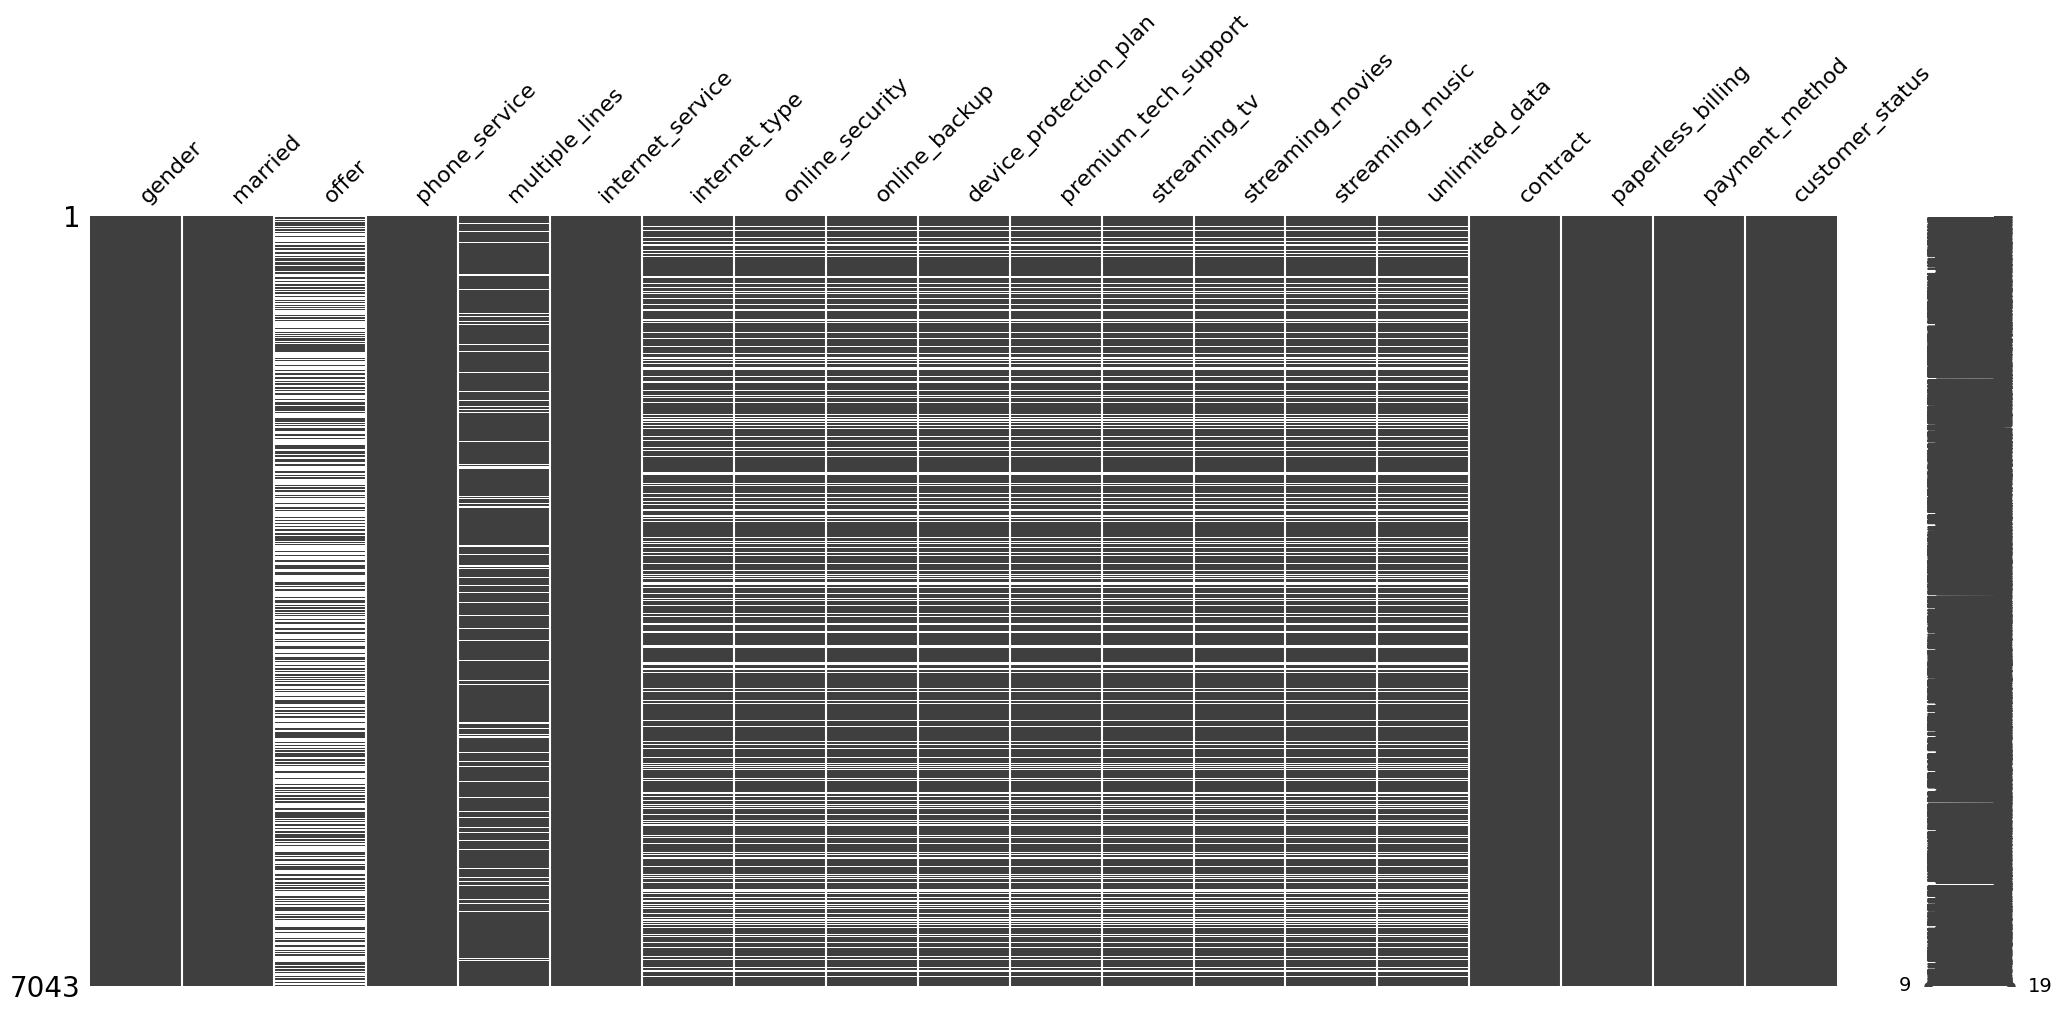

In [ ]:
# checking null values
print(f"null values in nominal features:\n{data.select_dtypes(include=['object']).isna().sum()}")
msno.matrix(data.select_dtypes(include=['object']))

In [ ]:
# filling null values
data['internet_type'] = data['internet_type'].apply(lambda x: 'no_internet_service' if pd.isnull(x) else x)
data['offer'] = data['offer'].apply(lambda x: 'no_offer' if pd.isnull(x) else x)

column_name = ['online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support',
               'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']
for column in column_name:
  data[column] = data[column].apply(lambda x: 'no_internet_service' if pd.isnull(x) else x)

<Axes: >

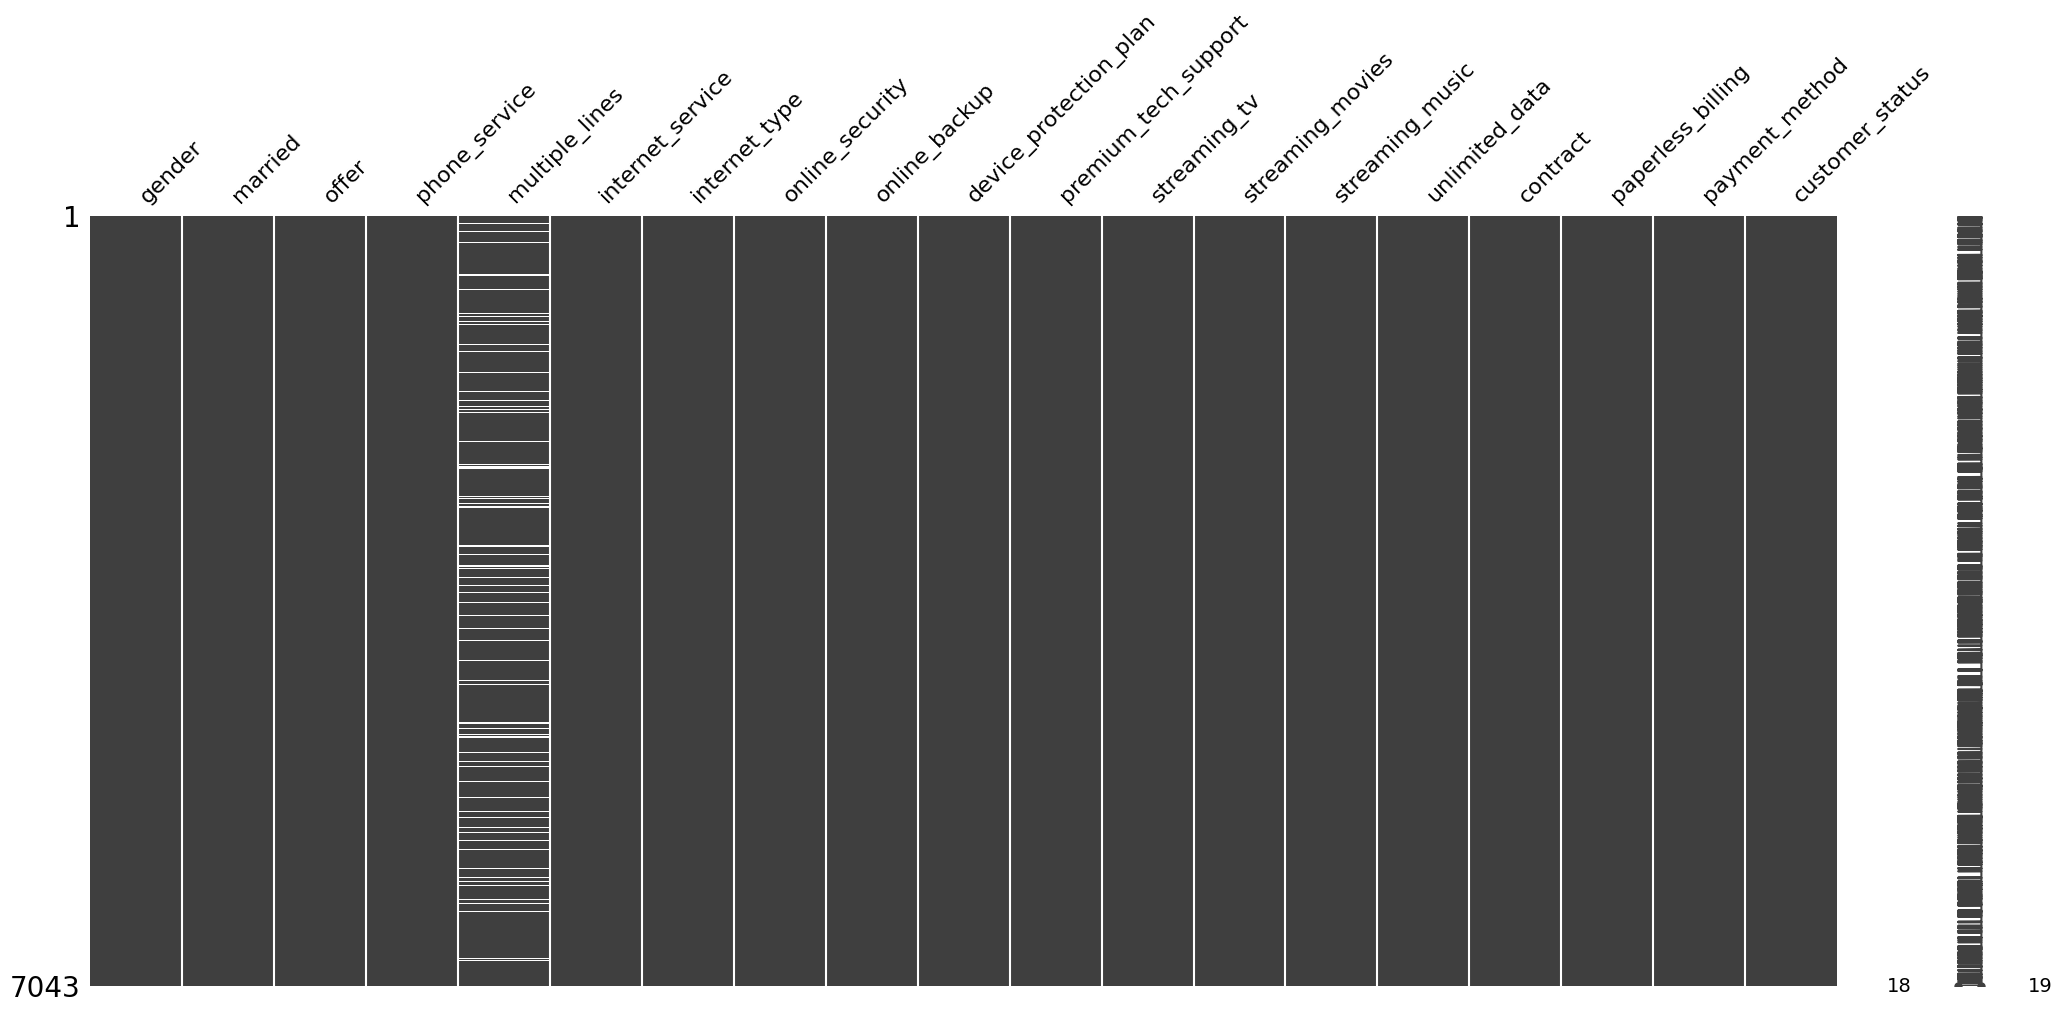

In [ ]:
msno.matrix(data.select_dtypes(include=['object']))

In [ ]:
print("null values in numerical features:\n",data.select_dtypes(include=['number']).isna().sum())

null values in numerical features:
 age                                     0
tenure_in_months                        0
avg_monthly_long_distance_charges     682
avg_monthly_gb_download              1526
monthly_charge                          0
total_revenue                           0
number_of_dependents_sqrt               0
number_of_referrals_sqrt                0
total_refunds_log                       0
total_extra_data_charges_log            0
total_long_distance_charges_sqrt        0
dtype: int64


In [ ]:
# filling null values
column_name = ['avg_monthly_long_distance_charges', 'avg_monthly_gb_download']
for column in column_name:
  data[column] = data[column].apply(lambda x: 0 if pd.isnull(x) else x)

null values in numerical features:
 age                                  0
tenure_in_months                     0
avg_monthly_long_distance_charges    0
avg_monthly_gb_download              0
monthly_charge                       0
total_revenue                        0
number_of_dependents_sqrt            0
number_of_referrals_sqrt             0
total_refunds_log                    0
total_extra_data_charges_log         0
total_long_distance_charges_sqrt     0
dtype: int64


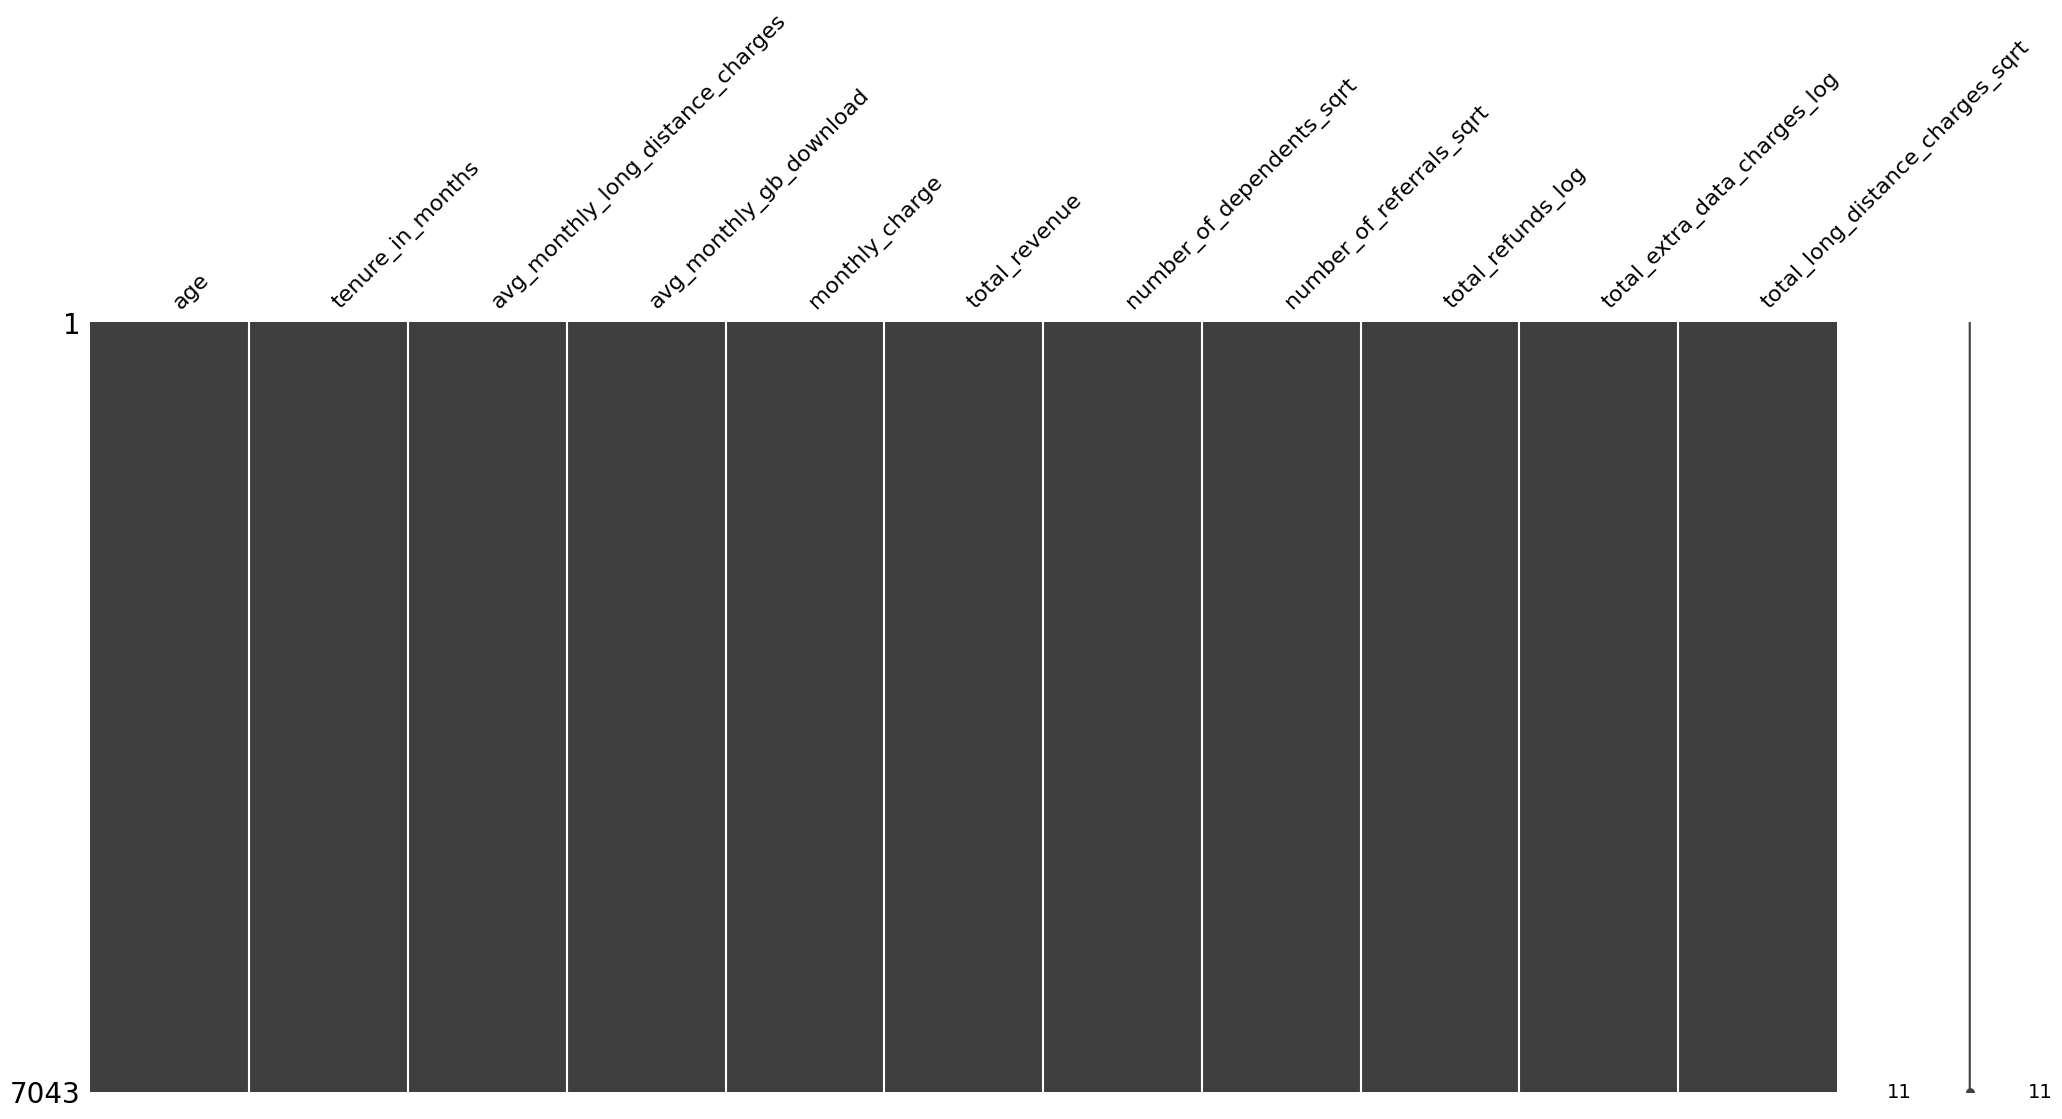

In [ ]:
# checking null values
msno.matrix(data.select_dtypes(include=['number']))
print("null values in numerical features:\n",data.select_dtypes(include=['number']).isna().sum())

# **Lable Encoding**

In [ ]:
# first step:
conversion_dict = {"Yes": 1, "No": 0}
data['multiple_lines'] = data['multiple_lines'].map(conversion_dict)

# second step: labeling the target by using LabelEncoder
label_encoder = LabelEncoder()
data['customer_status'] = label_encoder.fit_transform(data['customer_status'])

# third step: using pd.get_dummies for other features
data = pd.get_dummies(data, drop_first=True)

In [ ]:
# Extract the label column before imputation
label_column = data['customer_status']
data = data.drop(columns=['customer_status'])

# the KNNImputer
imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(data)

# If we want to keep the DataFrame format:
data = pd.DataFrame(data=imputed_data, columns=data.columns)


# Round the imputed values for 'multiple_lines' to get the mode
data['multiple_lines'] = data['multiple_lines'].apply(lambda x: round(x))

# Reattach the label column
data['customer_status'] = label_column

<Axes: >

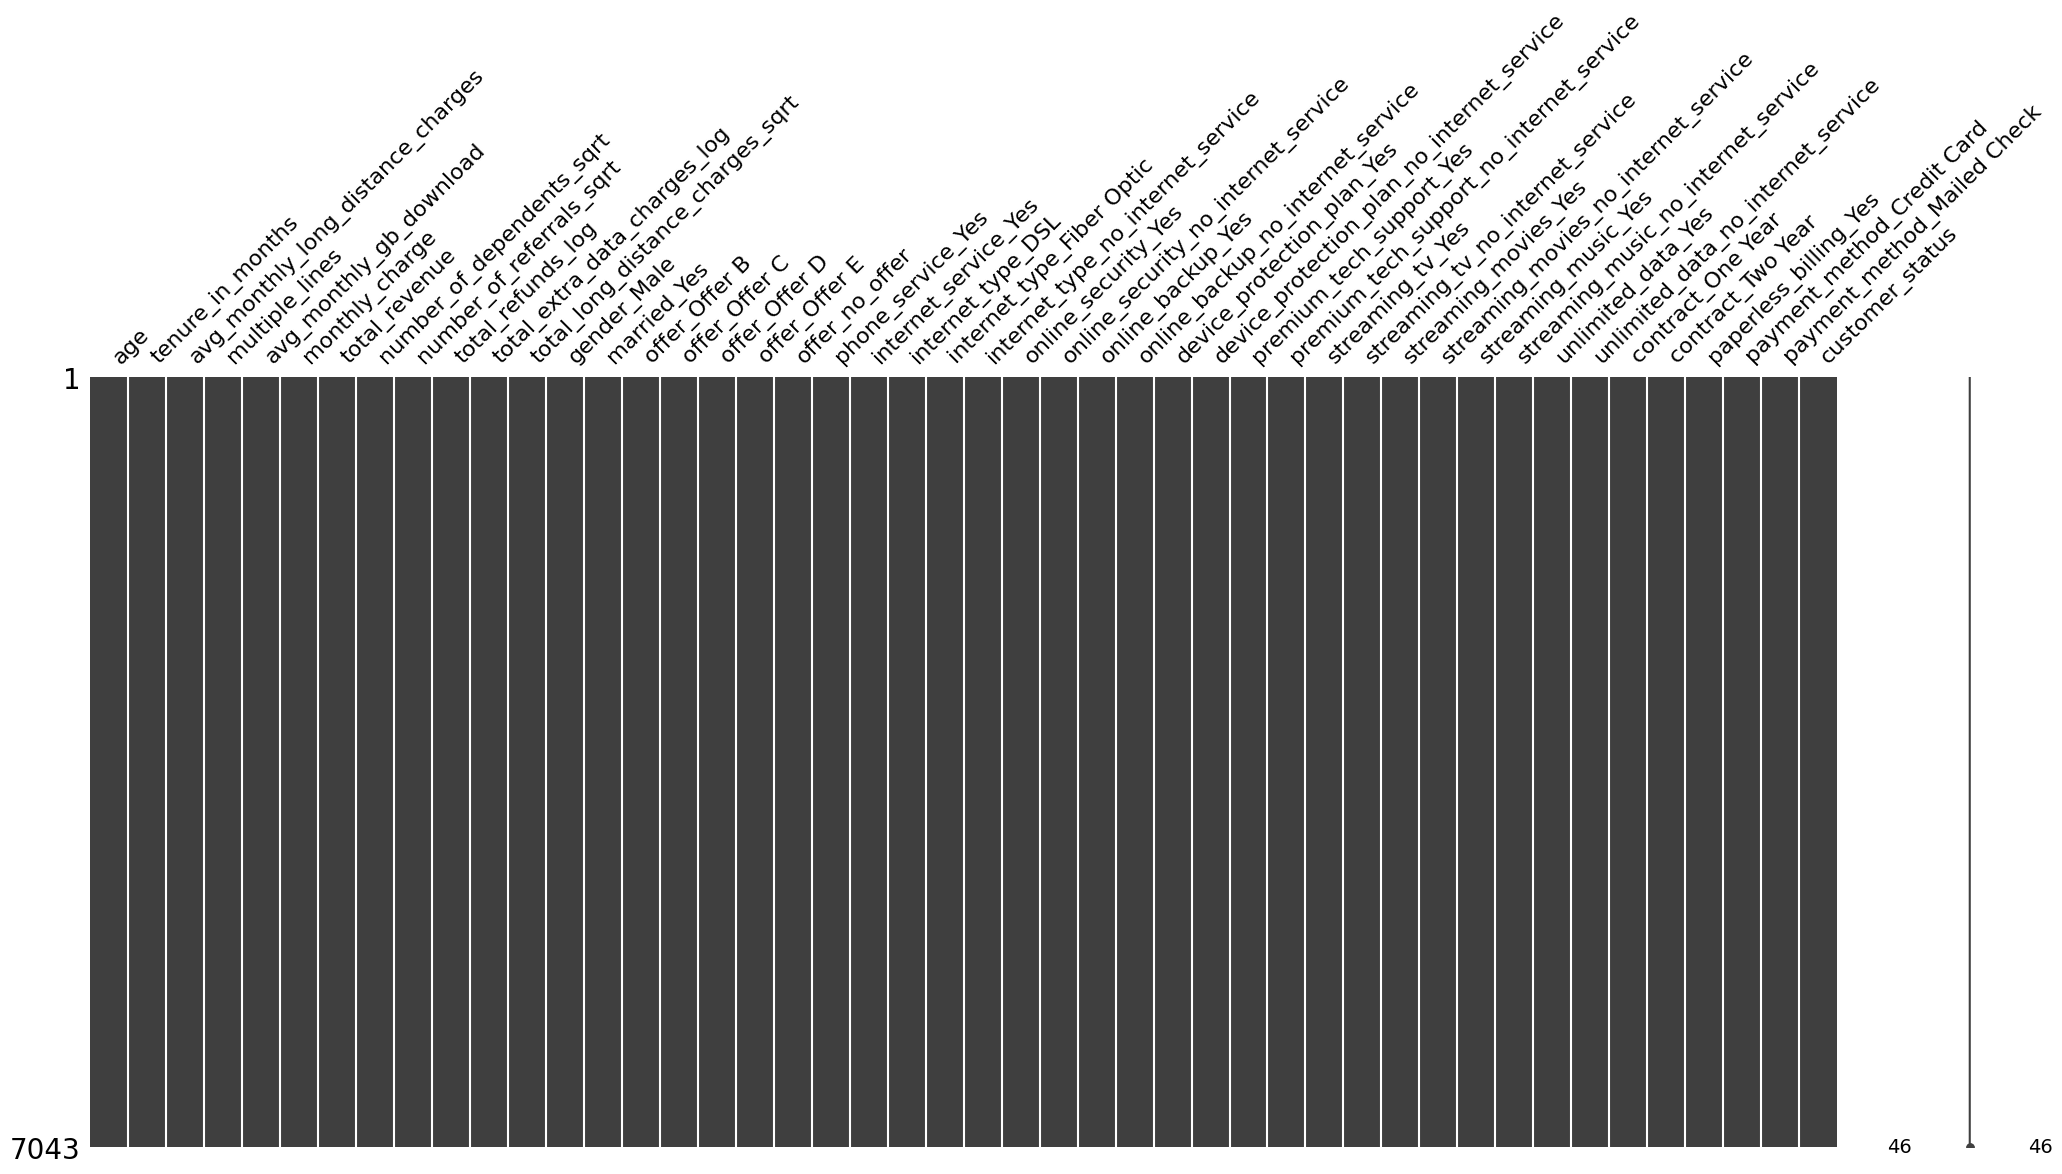

In [ ]:
# checking missing value
msno.matrix(data)

# **Split & Train**

In [ ]:
X = data.drop(['customer_status'], axis=1)
y = data.loc[:, 'customer_status'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=data.customer_status)

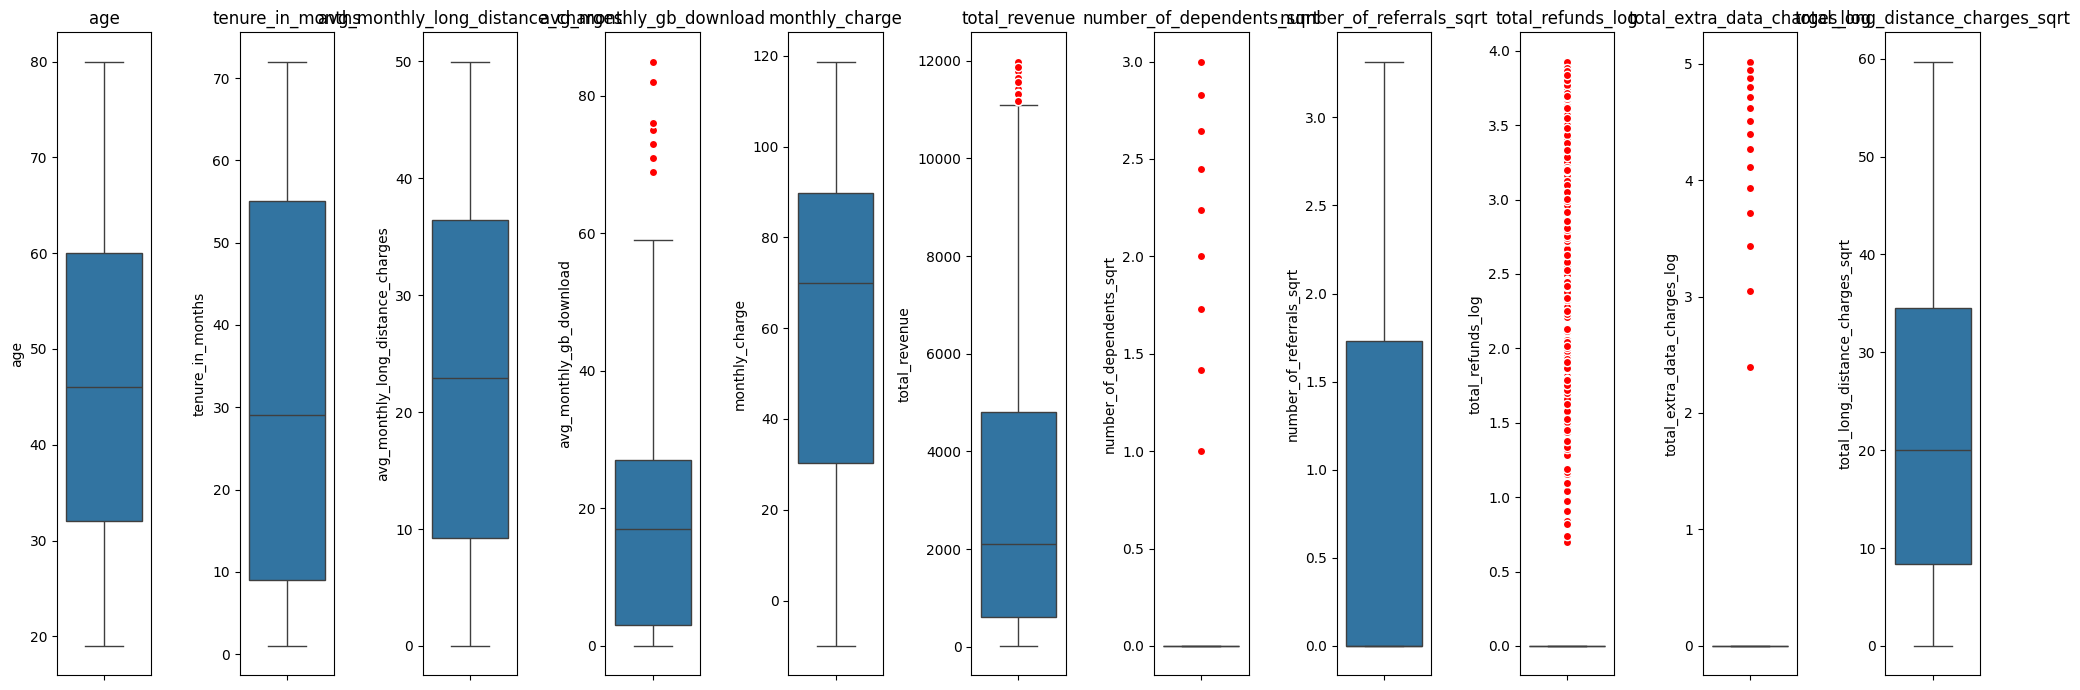

In [ ]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

numerical_columns = ['age', 'tenure_in_months', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'monthly_charge',
                  'total_revenue', 'number_of_dependents_sqrt', 'number_of_referrals_sqrt', 'total_refunds_log',
                  'total_extra_data_charges_log', 'total_long_distance_charges_sqrt']

# Create boxplots for numerical columns
num_plots = len(numerical_columns)

fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(20, 7))

for index, col in enumerate(numerical_columns):
    sns.boxplot(y=data[col], ax=axes[index], flierprops=red_circle)
    axes[index].set_ylabel(col)
    axes[index].set_title(col)

plt.tight_layout()
plt.show()


In [ ]:
# outlier data
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [ ]:
outlier_detection = data[numerical_columns]
for k, v in outlier_detection.items():
        outliers = find_outliers_IQR(v)
        perc = len(find_outliers_IQR(v)) * 100.0 / np.shape(outlier_detection)[0]
        print(f'Column :{k}')
        print(f"Number of Outliers = {len(outliers)}","||",f"Max Outlier Value = {outliers.max()}",
              "||", f"Min Outlier Value = {outliers.min()}", "||", f"Percentage of Outliers = {perc:.2f}%")
        print("\n")

Column :age
Number of Outliers = 0 || Max Outlier Value = nan || Min Outlier Value = nan || Percentage of Outliers = 0.00%


Column :tenure_in_months
Number of Outliers = 0 || Max Outlier Value = nan || Min Outlier Value = nan || Percentage of Outliers = 0.00%


Column :avg_monthly_long_distance_charges
Number of Outliers = 0 || Max Outlier Value = nan || Min Outlier Value = nan || Percentage of Outliers = 0.00%


Column :avg_monthly_gb_download
Number of Outliers = 362 || Max Outlier Value = 85.0 || Min Outlier Value = 69.0 || Percentage of Outliers = 5.14%


Column :monthly_charge
Number of Outliers = 0 || Max Outlier Value = nan || Min Outlier Value = nan || Percentage of Outliers = 0.00%


Column :total_revenue
Number of Outliers = 21 || Max Outlier Value = 11979.34 || Min Outlier Value = 11169.77 || Percentage of Outliers = 0.30%


Column :number_of_dependents_sqrt
Number of Outliers = 1627 || Max Outlier Value = 3.0 || Min Outlier Value = 1.0 || Percentage of Outliers = 23.10%




In [ ]:
def handle_outliers(X_train, X_test, columns):
    for col in columns:
        Q1 = np.percentile(X_train[col], 25)
        Q3 = np.percentile(X_train[col], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Handling outliers in X_train
        X_train[col] = np.where(X_train[col] < lower_bound, lower_bound, X_train[col])
        X_train[col] = np.where(X_train[col] > upper_bound, upper_bound, X_train[col])

        # Handling outliers in X_test based on X_train IQR
        X_test[col] = np.where(X_test[col] < lower_bound, lower_bound, X_test[col])
        X_test[col] = np.where(X_test[col] > upper_bound, upper_bound, X_test[col])

    return X_train, X_test


# Define the columns to apply outlier handling
columns_to_handle = ['avg_monthly_gb_download', 'total_revenue', 'number_of_dependents_sqrt',
                     'total_refunds_log', 'total_extra_data_charges_log']

# Apply the function to the specified columns
X_train, X_test = handle_outliers(X_train, X_test, columns_to_handle)

# **Scaling**

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [ ]:
data.head()

,age,tenure_in_months,avg_monthly_long_distance_charges,multiple_lines,avg_monthly_gb_download,monthly_charge,total_revenue,number_of_dependents_sqrt,number_of_referrals_sqrt,total_refunds_log,...,streaming_music_Yes,streaming_music_no_internet_service,unlimited_data_Yes,unlimited_data_no_internet_service,contract_One Year,contract_Two Year,paperless_billing_Yes,payment_method_Credit Card,payment_method_Mailed Check,customer_status
0,37.0,9.0,42.39,0,16.0,65.6,974.81,0.0,1.414214,0.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1
1,46.0,9.0,10.69,1,10.0,-4.0,610.28,0.0,0.000000,3.671988,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,50.0,4.0,33.65,0,30.0,73.9,415.45,0.0,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,78.0,13.0,27.82,0,4.0,98.0,1599.51,0.0,1.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,75.0,3.0,7.38,0,11.0,83.9,289.54,0.0,1.732051,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0


In [ ]:
# Count the values of y_train
y_train_counts = pd.Series(y_train).value_counts()

print("Counts of each class in y_train:")
print(y_train_counts)

Counts of each class in y_train:
1    4139
0    1495
Name: count, dtype: int64


In [ ]:
# # SMOTETomek

# # Apply SMOTETomek to the training data
# smote_tomek = SMOTETomek(random_state=42)
# X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# # Check the class distribution after resampling
# print('Resampled training set shape:\n', pd.Series(y_train_resampled).value_counts())

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Apply RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Check class distribution
print('Resampled training set shape:\n', pd.Series(y_train_resampled).value_counts())

Resampled training set shape:
 0    1495
1    1495
Name: count, dtype: int64


In [ ]:
# import xgboost as xgb
# from sklearn.metrics import f1_score, classification_report, accuracy_score
# from sklearn.model_selection import GridSearchCV
# import numpy as np
# import pandas as pd

# # Define the hyperparameter grid for grid search
# param_grid = {
#     'learning_rate': [0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [2, 3, 5],
#     'subsample': [0.6, 0.7, 0.8],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'min_child_weight': [1, 3, 5],
#     'reg_alpha': [0, 0.1],
#     'reg_lambda': [1.0, 1.5]
# }

# # Initialize XGBoost model
# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='f1_macro',  # Optimize for F1 macro to balance precision and recall
#     cv=5,                # 5-fold cross-validation
#     n_jobs=-1,           # Use all available CPUs
#     verbose=1
# )

# # Fit grid search on resampled training data
# grid_search.fit(X_train_resampled, y_train_resampled)

# # Get best parameters and best cross-validation score
# best_params = grid_search.best_params_
# best_cv_score = grid_search.best_score_
# print("Best Parameters:", best_params)
# print("Best Cross-Validation F1 Macro Score:", best_cv_score)

# # Use the best model from grid search
# best_model = grid_search.best_estimator_

# # Predict on training and test sets
# y_train_pred = best_model.predict(X_train_resampled)
# y_test_pred = best_model.predict(X_test)

# # Calculate accuracy and F1 scores
# train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# train_f1 = f1_score(y_train_resampled, y_train_pred, average='macro')
# test_f1 = f1_score(y_test, y_test_pred, average='macro')

# # Print results
# print("\nTraining Accuracy:", train_accuracy)
# print("Training F1 Score (macro):", train_f1)
# print("Test Accuracy:", test_accuracy)
# print("Test F1 Score (macro):", test_f1)
# print("\nClassification Report (Test Set):")
# print(classification_report(y_test, y_test_pred))

# # Check for overfitting
# if train_f1 > best_cv_score + 0.05 and train_f1 > test_f1 + 0.05:
#     print("\nWarning: Potential overfitting detected.")
# else:
#     print("\nNo strong evidence of overfitting.")

# # Print feature importance
# feature_importance = pd.DataFrame({
#     'feature': X_train_resampled.columns,
#     'importance': best_model.feature_importances_
# }).sort_values(by='importance', ascending=False)
# print("\nFeature Importance:\n", feature_importance)

In [ ]:
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# Use the best parameters from grid search
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 100,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 0.7
}

# Initialize XGBoost model with best parameters
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')

# Perform 5-fold cross-validation to assess generalization
cv_scores = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Train the model on the full resampled data
best_model.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
y_train_pred = best_model.predict(X_train_resampled)
y_test_pred = best_model.predict(X_test)

# Calculate accuracy and F1 scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train_resampled, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

# Print results
print("Cross-Validation Accuracy Scores (each fold):", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))
print("Standard Deviation of CV Accuracy:", np.std(cv_scores))
print("\nTraining Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Training F1 Score (macro):", train_f1)
print("Test F1 Score (macro):", test_f1)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Check for overfitting
cv_accuracy = np.mean(cv_scores)
cv_std = np.std(cv_scores)
if train_accuracy > cv_accuracy + cv_std and train_accuracy > test_accuracy + 0.05:
    print("\nWarning: Potential overfitting detected.")
else:
    print("\nNo strong evidence of overfitting.")

# Print feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_resampled.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)

Cross-Validation Accuracy Scores (each fold): [0.82441472 0.8361204  0.79431438 0.81438127 0.80769231]
Mean Cross-Validation Accuracy: 0.8153846153846154
Standard Deviation of CV Accuracy: 0.01425235836298495

Training Accuracy: 0.8505016722408026
Test Accuracy: 0.8161816891412349
Training F1 Score (macro): 0.8503375978788617
Test F1 Score (macro): 0.7894560419367476

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.61      0.87      0.71       374
           1       0.94      0.80      0.86      1035

    accuracy                           0.82      1409
   macro avg       0.78      0.83      0.79      1409
weighted avg       0.85      0.82      0.82      1409


No strong evidence of overfitting.

Feature Importance:
                                        feature  importance
41                           contract_Two Year    0.206066
20                        internet_service_Yes    0.148906
40                           cont

In [ ]:
# import pickle
# from google.colab import files

# model_filename = 'trained_model.pkl'
# with open(model_filename, 'wb') as file:
#     pickle.dump(model, file)

# print(f"Model saved to {model_filename}")

# files.download(model_filename)

# print(f"If you are in Google Colab, the file '{model_filename}' should be downloading to your local machine.")

In [ ]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
import xgboost as xgb

# PLEASE NOTE:
# This script assumes that you have already run your entire Colab notebook
# and the following variables are populated in your environment:
# - data: The DataFrame after initial loading, renaming, and dropping irrelevant columns,
#         but BEFORE any transformations (skew, null filling, encoding, etc.) specific to feature engineering.
#         Essentially, 'data' should be at the state right after this line in your script:
#         `data = data.drop(['total_charges'],axis=1)`
#
# - label_encoder: The fitted LabelEncoder for 'customer_status'.
# - imputer: The fitted KNNImputer.
# - scaler: The fitted StandardScaler.
# - best_model: Your trained XGBoost model.
# - X: The DataFrame used for features (data.drop(['customer_status'], axis=1))
#      *after* all preprocessing steps (skew, nulls, mapping, get_dummies)
#      but *before* imputation, outlier handling, scaling, and train_test_split.
#      This 'X' is what the imputer was fit on.
#
# - X_train: The training features DataFrame *before* RandomUnderSampler but *after* train_test_split.
#            This is used to derive outlier bounds and fit the scaler.
#
# - numerical_columns: The list of numerical column names used for scaling.
#   (e.g., ['age', 'tenure_in_months', ...])
#
# - columns_to_handle_outliers: The list of columns on which outlier handling was applied.
#   (e.g., ['avg_monthly_gb_download', 'total_revenue', ...])
#
# - columns_to_transform_skew: The original names of columns that underwent skew transformation.
#   (e.g., ['number_of_dependents', 'number_of_referrals', ...])
#
# - final_training_columns: The list of columns in X_train_resampled.columns or X_test.columns.
#                           This is the exact set of features the model expects.

# --- You might need to re-run parts of your notebook to get these variables in the correct state ---
# --- Or adjust this script to match how they are named in your final notebook state ---

print("Starting artifact saving process...")

# --- Recreate variables if necessary (Example based on your script) ---

# Load data as in your script
original_data = pd.read_csv('telecom_customer_churn.csv')
data_for_preprocessing = original_data.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns')
data_for_preprocessing['customer_status'] = data_for_preprocessing['customer_status'].replace('Joined', 'Stayed')
# Initial drops
cols_to_drop_initial = ['customer_id', 'city', 'zip_code', 'latitude', 'longitude', 'churn_category', 'churn_reason', 'total_charges']
data_for_preprocessing = data_for_preprocessing.drop(columns=[col for col in cols_to_drop_initial if col in data_for_preprocessing.columns])

# --- Transformations (as in your script to define X) ---
# Skewness transformations
columns_to_transform_skew = ['number_of_dependents', 'number_of_referrals', 'total_refunds',
                             'total_extra_data_charges', 'total_long_distance_charges']

# Store which transformation was applied for the preprocessing function
# This is based on your script's logic of dropping columns
skew_transform_map = {
    'number_of_dependents': 'sqrt',
    'number_of_referrals': 'sqrt',
    'total_refunds': 'log',
    'total_extra_data_charges': 'log',
    'total_long_distance_charges': 'sqrt'
}
with open('skew_transform_map.json', 'w') as f:
    json.dump(skew_transform_map, f)

# Apply transformations to create the columns that will be kept
data_proc = data_for_preprocessing.copy()
if 'number_of_dependents' in data_proc.columns:
    data_proc['number_of_dependents_sqrt'] = np.sqrt(data_proc['number_of_dependents'])
if 'number_of_referrals' in data_proc.columns:
    data_proc['number_of_referrals_sqrt'] = np.sqrt(data_proc['number_of_referrals'])
if 'total_refunds' in data_proc.columns:
    data_proc['total_refunds_log'] = np.log1p(data_proc['total_refunds'])
if 'total_extra_data_charges' in data_proc.columns:
    data_proc['total_extra_data_charges_log'] = np.log1p(data_proc['total_extra_data_charges'])
if 'total_long_distance_charges' in data_proc.columns:
    data_proc['total_long_distance_charges_sqrt'] = np.sqrt(data_proc['total_long_distance_charges'])

# Drop original and unused transformed columns (as per your script)
cols_to_drop_after_skew = [
    'number_of_dependents', 'number_of_dependents_log',
    'number_of_referrals', 'number_of_referrals_log',
    'total_refunds', 'total_refunds_sqrt',
    'total_extra_data_charges', 'total_extra_data_charges_sqrt',
    'total_long_distance_charges', 'total_long_distance_charges_log'
]
data_proc = data_proc.drop(columns=[col for col in cols_to_drop_after_skew if col in data_proc.columns], errors='ignore')

# Null value filling
data_proc['internet_type'] = data_proc['internet_type'].fillna('no_internet_service') # Adjusted to fillna
data_proc['offer'] = data_proc['offer'].fillna('no_offer') # Adjusted to fillna

cols_fill_no_internet = ['online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support',
                         'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']
for column in cols_fill_no_internet:
    if column in data_proc.columns:
        data_proc[column] = data_proc[column].fillna('no_internet_service') # Adjusted to fillna

cols_fill_zero = ['avg_monthly_long_distance_charges', 'avg_monthly_gb_download']
for column in cols_fill_zero:
    if column in data_proc.columns:
        data_proc[column] = data_proc[column].fillna(0) # Adjusted to fillna

# Encoding 'multiple_lines'
if 'multiple_lines' in data_proc.columns:
    conversion_dict_multiple_lines = {"Yes": 1, "No": 0}
    data_proc['multiple_lines'] = data_proc['multiple_lines'].map(conversion_dict_multiple_lines)

# Label Encoding for target
label_encoder = LabelEncoder()
if 'customer_status' in data_proc.columns:
    data_proc['customer_status'] = label_encoder.fit_transform(data_proc['customer_status'])
    joblib.dump(label_encoder, 'label_encoder.pkl') # Save the fitted LabelEncoder
    print("Saved label_encoder.pkl")
    # Save classes for easier interpretation later
    label_encoder_classes = label_encoder.classes_.tolist()
    with open('label_encoder_classes.json', 'w') as f:
        json.dump(label_encoder_classes, f)
    print(f"Saved label_encoder_classes.json with classes: {label_encoder_classes}")
else:
    print("Warning: 'customer_status' column not found for LabelEncoder.")


# Get_dummies for other features
# Identify categorical columns for get_dummies (excluding already processed 'multiple_lines' if it was object)
categorical_cols_for_dummies = data_proc.select_dtypes(include=['object']).columns.tolist()
data_proc = pd.get_dummies(data_proc, columns=categorical_cols_for_dummies, drop_first=True)


# Define X (features before imputation) and y (target)
if 'customer_status' in data_proc.columns:
    X = data_proc.drop(columns=['customer_status'])
    y = data_proc['customer_status']
else:
    print("Error: 'customer_status' not in processed data. Cannot define X and y.")
    # Handle error or exit if necessary
    X = data_proc.copy() # Fallback if target is missing, though this is not ideal
    y = pd.Series() # Empty series

# Save the columns of X at this stage (after dummies, before imputation)
# These are the columns KNNImputer will be fit on.
# And also the reference for final model input columns.
x_columns_before_imputation = X.columns.tolist()
with open('x_columns_before_imputation.json', 'w') as f:
    json.dump(x_columns_before_imputation, f)
print(f"Saved x_columns_before_imputation.json with {len(x_columns_before_imputation)} columns.")

# KNN Imputation
imputer = KNNImputer(n_neighbors=3)
# Ensure X has some data before fitting
if not X.empty:
    imputed_values = imputer.fit_transform(X)
    X_imputed = pd.DataFrame(data=imputed_values, columns=X.columns)
    joblib.dump(imputer, 'imputer.pkl')
    print("Saved imputer.pkl")

    # Round 'multiple_lines' after imputation if it exists
    if 'multiple_lines' in X_imputed.columns:
        X_imputed['multiple_lines'] = X_imputed['multiple_lines'].round()
else:
    print("Warning: X is empty, KNNImputer not fitted or saved.")
    X_imputed = X.copy() # Keep X as is if empty


# Train-test split (as in your notebook to get X_train for scaler and outlier bounds)
# This assumes y is correctly defined
if not X_imputed.empty and not y.empty:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
    )
else:
    print("Warning: X_imputed or y is empty. Train-test split skipped. Scaler and outlier bounds might be incorrect.")
    # Create dummy X_train, X_test if they don't exist to prevent script from crashing
    # This is a fallback, actual values from notebook are preferred
    X_train = X_imputed.sample(frac=0.8, random_state=42) if not X_imputed.empty else pd.DataFrame()
    X_test = X_imputed.drop(X_train.index) if not X_imputed.empty else pd.DataFrame()


# Outlier Handling Bounds (calculated on X_train)
# These are the columns defined in your script for outlier handling
columns_to_handle_outliers = ['avg_monthly_gb_download', 'total_revenue', 'number_of_dependents_sqrt',
                              'total_refunds_log', 'total_extra_data_charges_log']
outlier_bounds = {}
if not X_train.empty:
    for col in columns_to_handle_outliers:
        if col in X_train.columns:
            Q1 = np.percentile(X_train[col].dropna(), 25) # dropna for safety
            Q3 = np.percentile(X_train[col].dropna(), 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_bounds[col] = {'lower': lower_bound, 'upper': upper_bound}
        else:
            print(f"Warning: Column {col} for outlier handling not found in X_train.")
    with open('outlier_bounds.json', 'w') as f:
        json.dump(outlier_bounds, f)
    print(f"Saved outlier_bounds.json for columns: {list(outlier_bounds.keys())}")
else:
    print("Warning: X_train is empty. Outlier bounds not calculated or saved.")


# Numerical columns for scaling (as defined in your script)
numerical_columns_for_scaling = [
    'age', 'tenure_in_months', 'avg_monthly_long_distance_charges',
    'avg_monthly_gb_download', 'monthly_charge', 'total_revenue',
    'number_of_dependents_sqrt', 'number_of_referrals_sqrt', 'total_refunds_log',
    'total_extra_data_charges_log', 'total_long_distance_charges_sqrt'
]
# Filter to only include columns present in X_train
actual_numerical_columns_for_scaling = [col for col in numerical_columns_for_scaling if col in X_train.columns]
if not actual_numerical_columns_for_scaling:
    print(f"Warning: None of the specified numerical_columns_for_scaling were found in X_train. Scaler might not be effective.")


# StandardScaler (fitted on X_train numerical columns)
scaler = StandardScaler()
if not X_train.empty and actual_numerical_columns_for_scaling:
    # Ensure X_train is a DataFrame for this operation
    if isinstance(X_train, pd.DataFrame) and not X_train[actual_numerical_columns_for_scaling].empty:
        scaler.fit(X_train[actual_numerical_columns_for_scaling])
        joblib.dump(scaler, 'scaler.pkl')
        print("Saved scaler.pkl")
        with open('numerical_columns_for_scaling.json', 'w') as f:
            json.dump(actual_numerical_columns_for_scaling, f)
        print(f"Saved numerical_columns_for_scaling.json with columns: {actual_numerical_columns_for_scaling}")
    else:
        print(f"Warning: X_train numerical columns subset is empty or not a DataFrame. Scaler not fitted.")
else:
    print("Warning: X_train is empty or no numerical columns found. Scaler not fitted or saved.")
    # Save an empty list if not saved
    with open('numerical_columns_for_scaling.json', 'w') as f:
        json.dump([], f)


# Save the trained XGBoost model (ensure 'best_model' is your trained model variable)
# Example: Re-train the model here if 'best_model' is not in the environment
# This part assumes your 'best_model' is already trained and available.
# If not, you need to include your model training code here.
# For this example, let's assume best_model is loaded or trained.
# best_model = xgb.XGBClassifier(...)
# best_model.fit(X_train_resampled, y_train_resampled) # From your script
try:
    # This assumes 'best_model' is already defined and trained in your notebook
    joblib.dump(best_model, 'model.pkl')
    print("Saved model.pkl")
except NameError:
    print("Error: 'best_model' is not defined. Please ensure your model is trained and named 'best_model'.")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")


# Final columns expected by the model (from X_train_resampled or X_test)
# These should be the same as x_columns_before_imputation if no columns were added/dropped by imputer/outlier/scaler
# However, it's safer to use the columns from data that directly goes into the model.
# If you used X_train_resampled.columns for training, save that.
# For simplicity, we'll stick to x_columns_before_imputation, assuming their structure is maintained.
# If RandomUnderSampler changes column names or types (unlikely for columns), adjust accordingly.
# The critical thing is that the `preprocess_input` function in `utils.py` must produce these exact columns in this order.
final_model_columns = x_columns_before_imputation # Assuming structure is preserved
with open('final_model_columns.json', 'w') as f:
    json.dump(final_model_columns, f)
print(f"Saved final_model_columns.json with {len(final_model_columns)} columns. These are the columns your model expects.")


print("--- Artifact saving process completed. ---")
print("Please check your directory for the .pkl and .json files.")
print("Files created: model.pkl, scaler.pkl, imputer.pkl, label_encoder.pkl, label_encoder_classes.json, ")
print("x_columns_before_imputation.json, outlier_bounds.json, numerical_columns_for_scaling.json, final_model_columns.json, skew_transform_map.json")



Starting artifact saving process...
Saved label_encoder.pkl
Saved label_encoder_classes.json with classes: ['Churned', 'Stayed']
Saved x_columns_before_imputation.json with 45 columns.
Saved imputer.pkl
Saved outlier_bounds.json for columns: ['avg_monthly_gb_download', 'total_revenue', 'number_of_dependents_sqrt', 'total_refunds_log', 'total_extra_data_charges_log']
Saved scaler.pkl
Saved numerical_columns_for_scaling.json with columns: ['age', 'tenure_in_months', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'monthly_charge', 'total_revenue', 'number_of_dependents_sqrt', 'number_of_referrals_sqrt', 'total_refunds_log', 'total_extra_data_charges_log', 'total_long_distance_charges_sqrt']
Saved model.pkl
Saved final_model_columns.json with 45 columns. These are the columns your model expects.
--- Artifact saving process completed. ---
Please check your directory for the .pkl and .json files.
Files created: model.pkl, scaler.pkl, imputer.pkl, label_encoder.pkl, label_enc